In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from time import time

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy import interpolate

print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
import pickle
with open("cyc_ch_aging_results_200days.pkl", "rb") as file:
    data = pickle.load(file)
    
input_grid = np.array(data["input"]) # Temperature, C-rate
output_grid = data["output"] # Ah_ch, Q_loss_cyc, avg T, Time_Q, Q_loss_cal, Time, Current, Temp, cycle 1 time, cycle 1 current, cycle 1 temp, Ah_dch, avg_T_dch
exp_freq = 40

In [3]:
R_const = 8.314

In [4]:
# Q_loss_ch_arr_concat = []
# for i in range(len(output_grid)):
#     Q_loss_cyc_arr = output_grid[i][1]
#     Q_loss_ch_arr = Q_loss_cyc_arr
#     Q_loss_ch_arr_concat.append(Q_loss_ch_arr)

In [5]:
with open('ECM_cyc_Ea.pkl', 'rb') as f:
    Ea_save = pickle.load(f)
with open('ECM_cyc_B.pkl', 'rb') as f:
    interp_func1 = pickle.load(f)
with open('ECM_cyc_z.pkl', 'rb') as f:
    z_save = pickle.load(f)  

In [8]:
print(interp_func1([[0.1,0.5,1.0,1.5,2.0]]))
print(Ea_save)
print(z_save)

[[1.65986941e-08 2.43325763e-08 3.94633546e-08 6.02000772e-08
  1.18743516e-07]]
23799.12135155978
1.0494671681400614


In [6]:
val_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
input_val = input_grid[val_idx]
output_val = [output_grid[i] for i in val_idx]

temperature_K_candi = list(sorted(set(np.array(input_val)[:,0]+ 273.15)))
c_rate_candi = list(sorted(set(np.array(input_val)[:,1])))
                
print(temperature_K_candi)
print(c_rate_candi)

x_ch_models = []
x_dch_models = []
y_exps = []
Temps_ch = []
Temps_dch = []
for i in range(len(val_idx)):
    index = val_idx[i]
    x_temp = np.array(output_grid[index][0])[::exp_freq] # Ah_ch
    x_ch_models.append(x_temp)
    x_temp = np.array(output_grid[index][11])[::exp_freq] # Ah_dch
    x_dch_models.append(x_temp)  
    
    y_temp = np.array(output_grid[index][1])[::exp_freq] # Q_loss_cyc
    y_exps.append(y_temp)    
    
    Temp_temp = np.array(output_grid[index][2]) # Temp_avg_ch
    Temps_ch.append(Temp_temp)
    Temp_temp = np.array(output_grid[index][12]) # Temp_avg_dch
    Temps_dch.append(Temp_temp)

def y_model(params,Ah,Temp, dch_Ah, dch_Temp):
    y_temp = params[0]*np.exp(params[1]/8.314/Temp)*Ah**params[2] + params[3]*np.exp(params[1]/8.314/dch_Temp)*dch_Ah**params[2]
    return y_temp

[288.15, 298.15, 308.15]
[0.1, 0.3, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]


In [7]:
for s, c_rate in enumerate(c_rate_candi):
    print(c_rate)
    fitted_params = [interp_func1(c_rate),Ea_save,z_save, interp_func1(0.1)]
    fitted_params = np.array(fitted_params).flatten()
    
    x_model_T1 = x_ch_models[3*s]
    x_model_T2 = x_ch_models[3*s+1]
    x_model_T3 = x_ch_models[3*s+2]
    y_exp_T1 = y_exps[3*s]
    y_exp_T2 = y_exps[3*s+1]
    y_exp_T3 = y_exps[3*s+2]
    
    Temp_T1 = Temps_ch[3*s]
    Temp_T2 = Temps_ch[3*s+1]
    Temp_T3 = Temps_ch[3*s+2]
    
    x_model_T1_dch = x_dch_models[3*s]
    x_model_T2_dch = x_dch_models[3*s+1]
    x_model_T3_dch = x_dch_models[3*s+2]

    Temp_T1_dch = Temps_dch[3*s]
    Temp_T2_dch = Temps_dch[3*s+1]
    Temp_T3_dch = Temps_dch[3*s+2]
    
    def obj_func(fitted_params):
        y_model_T1 = y_model(fitted_params,x_model_T1,Temp_T1,x_model_T1_dch,Temp_T1_dch)
        y_model_T2 = y_model(fitted_params,x_model_T2,Temp_T2,x_model_T2_dch,Temp_T2_dch)
        y_model_T3 = y_model(fitted_params,x_model_T3,Temp_T3,x_model_T3_dch,Temp_T3_dch)
        rmse_T1 = np.sqrt(mean_squared_error(y_exp_T1, y_model_T1))
        rmse_T2 = np.sqrt(mean_squared_error(y_exp_T2, y_model_T2))
        rmse_T3 = np.sqrt(mean_squared_error(y_exp_T3, y_model_T3))
        rmse = np.mean([rmse_T1,rmse_T2,rmse_T3])
        return rmse_T1, rmse_T2, rmse_T3, rmse


    y_plot_T1 = y_model(fitted_params,x_model_T1,Temp_T1,x_model_T1_dch,Temp_T1_dch)
    y_plot_T2 = y_model(fitted_params,x_model_T2,Temp_T2,x_model_T2_dch,Temp_T2_dch)
    y_plot_T3 = y_model(fitted_params,x_model_T3,Temp_T3,x_model_T3_dch,Temp_T3_dch)

    print('Fitted parameters: ',fitted_params)
    print(f"RMSE: {obj_func(fitted_params)}")
#     plt.figure(1,figsize=(8,4))
#     plt.grid()
#     plt.scatter(x_model_T1+x_model_T1_dch, y_exp_T1,c='r',label='EM (15 °C)')
#     plt.plot(x_model_T1+x_model_T1_dch,y_plot_T1,c='r',label='model (15 °C)')
#     plt.scatter(x_model_T2+x_model_T2_dch, y_exp_T2,c='g',label='EM (25 °C)')
#     plt.plot(x_model_T2+x_model_T2_dch,y_plot_T2,c='g',label='model (25 °C)')
#     plt.scatter(x_model_T3+x_model_T3_dch, y_exp_T3,c='b',label='EM (35 °C)')
#     plt.plot(x_model_T3+x_model_T3_dch,y_plot_T3,c='b',label='model (35 °C)')
#     plt.legend()
#     plt.title(f'Charging c-rate: {c_rate} C')
#     plt.xlabel('Ah throughput [A.h]')
#     plt.ylabel('Cycling aging loss [A.h]')
#     plt.legend(ncol=3,fontsize=10)
#     plt.show()

0.1
Fitted parameters:  [1.65986941e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.06501858148268407, 0.003591162621461607, 0.015524215016051425, 0.028044653040065703)
0.3
Fitted parameters:  [2.04656352e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.05432422293820006, 0.005194582525710774, 0.015375466885649855, 0.02496475744985356)
0.5
Fitted parameters:  [2.43325763e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.04738861181550883, 0.004832615072905003, 0.021584477679499052, 0.024601901522637627)
0.75
Fitted parameters:  [3.18979654e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.017498744543870858, 0.02043590101425045, 0.01660508946388299, 0.018179911674001435)
1.0
Fitted parameters:  [3.94633546e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.014527760769202952, 0.024080392124765353, 0.02301942108636041, 0.020542524660109574)
1.25
Fitted parameters:  [4.98317159e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.01962

### Plotting for paper

In [8]:
val_idx = [3,4,5,9,10,11,15,16,17,21,22,23]
input_val = input_grid[val_idx]
output_val = [output_grid[i] for i in val_idx]

temperature_K_candi = list(sorted(set(np.array(input_val)[:,0]+ 273.15)))
c_rate_candi = list(sorted(set(np.array(input_val)[:,1])))
                
print(temperature_K_candi)
print(c_rate_candi)

x_ch_models = []
x_dch_models = []
y_exps = []
Temps_ch = []
Temps_dch = []
for i in range(len(val_idx)):
    index = val_idx[i]
    x_temp = np.array(output_grid[index][0])[::exp_freq] # Ah_ch
    x_ch_models.append(x_temp)
    x_temp = np.array(output_grid[index][11])[::exp_freq] # Ah_dch
    x_dch_models.append(x_temp)  
    
    y_temp = np.array(output_grid[index][1])[::exp_freq] # Q_loss_cyc
    y_exps.append(y_temp)    
    
    Temp_temp = np.array(output_grid[index][2]) # Temp_avg_ch
    Temps_ch.append(Temp_temp)
    Temp_temp = np.array(output_grid[index][12]) # Temp_avg_dch
    Temps_dch.append(Temp_temp)

def y_model(params,Ah,Temp, dch_Ah, dch_Temp):
    y_temp = params[0]*np.exp(params[1]/8.314/Temp)*Ah**params[2] + params[3]*np.exp(params[1]/8.314/dch_Temp)*dch_Ah**params[2]
    return y_temp

[288.15, 298.15, 308.15]
[0.3, 0.75, 1.25, 1.75]


In [9]:
np.ceil((x_model_T3+x_model_T3_dch)[-1]/250)

6.0

In [10]:
np.linspace(0,250*np.ceil((x_model_T3+x_model_T3_dch)[-1]/250),int(np.ceil((x_model_T3+x_model_T3_dch)[-1]/250)+1))

array([   0.,  250.,  500.,  750., 1000., 1250., 1500.])

0.3
Fitted parameters:  [2.04656352e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.05432422293820006, 0.005194582525710774, 0.015375466885649855, 0.02496475744985356)
0.75
Fitted parameters:  [3.18979654e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.017498744543870858, 0.02043590101425045, 0.01660508946388299, 0.018179911674001435)
1.25
Fitted parameters:  [4.98317159e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.019628254413320535, 0.031050946694103337, 0.02854806793905108, 0.026409089682158316)
1.75
Fitted parameters:  [8.94717967e-08 2.37991214e+04 1.04946717e+00 1.65986941e-08]
RMSE: (0.04546096813036485, 0.06147866984077206, 0.034256817148738385, 0.047065485039958437)


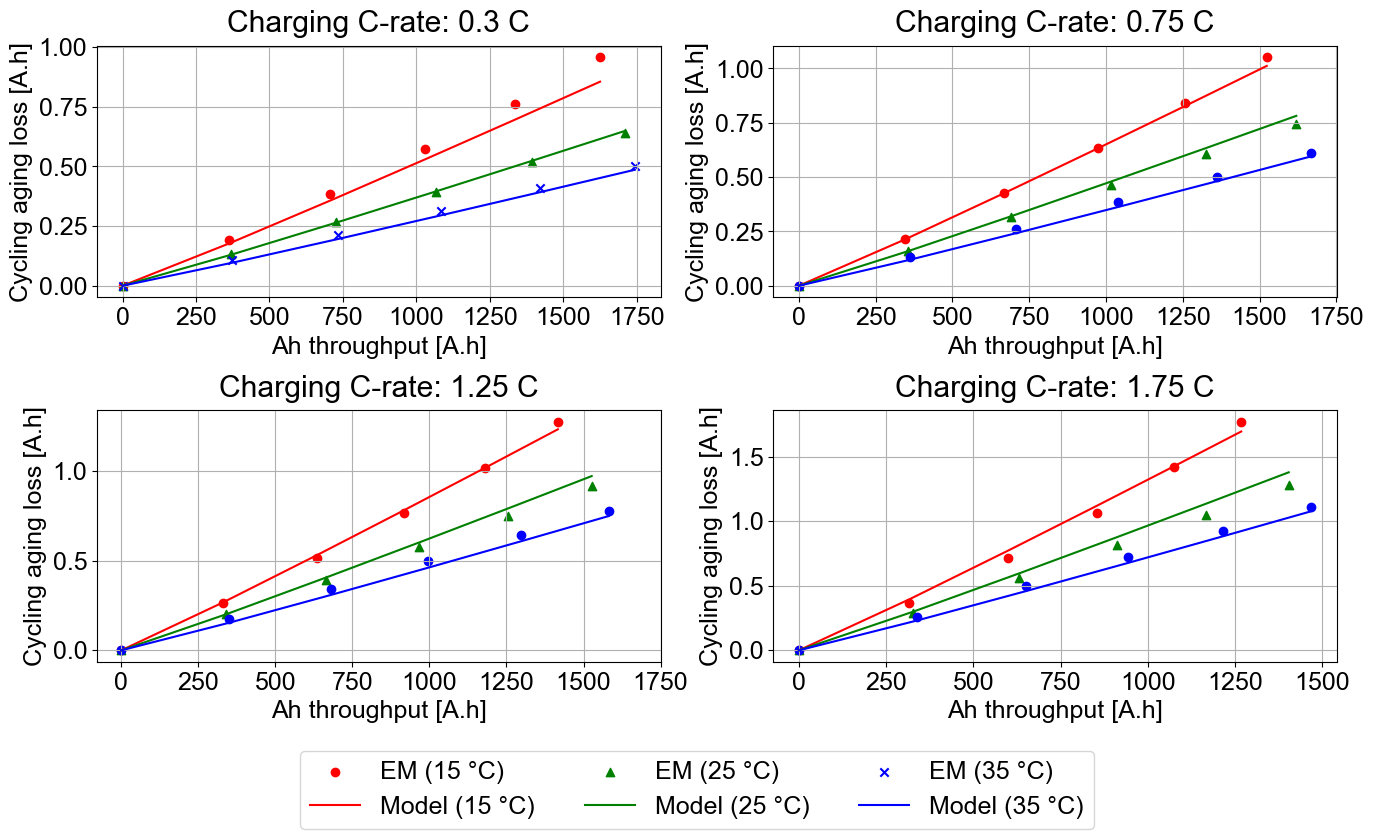

In [11]:
plt.rcParams['font.size'] = 18
for s, c_rate in enumerate(c_rate_candi):
    print(c_rate)
    fitted_params = [interp_func1(c_rate),Ea_save,z_save, interp_func1(0.1)]
    fitted_params = np.array(fitted_params).flatten()
    
    x_model_T1 = x_ch_models[3*s]
    x_model_T2 = x_ch_models[3*s+1]
    x_model_T3 = x_ch_models[3*s+2]
    y_exp_T1 = y_exps[3*s]
    y_exp_T2 = y_exps[3*s+1]
    y_exp_T3 = y_exps[3*s+2]
    
    Temp_T1 = Temps_ch[3*s]
    Temp_T2 = Temps_ch[3*s+1]
    Temp_T3 = Temps_ch[3*s+2]
    
    x_model_T1_dch = x_dch_models[3*s]
    x_model_T2_dch = x_dch_models[3*s+1]
    x_model_T3_dch = x_dch_models[3*s+2]

    Temp_T1_dch = Temps_dch[3*s]
    Temp_T2_dch = Temps_dch[3*s+1]
    Temp_T3_dch = Temps_dch[3*s+2]
    
    def obj_func(fitted_params):
        y_model_T1 = y_model(fitted_params,x_model_T1,Temp_T1,x_model_T1_dch,Temp_T1_dch)
        y_model_T2 = y_model(fitted_params,x_model_T2,Temp_T2,x_model_T2_dch,Temp_T2_dch)
        y_model_T3 = y_model(fitted_params,x_model_T3,Temp_T3,x_model_T3_dch,Temp_T3_dch)
        rmse_T1 = np.sqrt(mean_squared_error(y_exp_T1, y_model_T1))
        rmse_T2 = np.sqrt(mean_squared_error(y_exp_T2, y_model_T2))
        rmse_T3 = np.sqrt(mean_squared_error(y_exp_T3, y_model_T3))
        rmse = np.mean([rmse_T1,rmse_T2,rmse_T3])
        return rmse_T1, rmse_T2, rmse_T3, rmse


    y_plot_T1 = y_model(fitted_params,x_model_T1,Temp_T1,x_model_T1_dch,Temp_T1_dch)
    y_plot_T2 = y_model(fitted_params,x_model_T2,Temp_T2,x_model_T2_dch,Temp_T2_dch)
    y_plot_T3 = y_model(fitted_params,x_model_T3,Temp_T3,x_model_T3_dch,Temp_T3_dch)

    print('Fitted parameters: ',fitted_params)
    print(f"RMSE: {obj_func(fitted_params)}")
    fig = plt.figure(1,figsize=(16,8))
    plt.subplot(2,2,1+s)
    plt.grid()
    if s==0:
        plt.scatter(x_model_T1+x_model_T1_dch, y_exp_T1,c='r',marker='o',label='EM (15 °C)')
        plt.plot(x_model_T1+x_model_T1_dch,y_plot_T1,c='r',label='Model (15 °C)')
        plt.scatter(x_model_T2+x_model_T2_dch, y_exp_T2,c='g',marker='^',label='EM (25 °C)')
        plt.plot(x_model_T2+x_model_T2_dch,y_plot_T2,c='g',label='Model (25 °C)')
        plt.scatter(x_model_T3+x_model_T3_dch, y_exp_T3,c='b',marker='x',label='EM (35 °C)')
        plt.plot(x_model_T3+x_model_T3_dch,y_plot_T3,c='b',label='Model (35 °C)')
        
    else:
        plt.scatter(x_model_T1+x_model_T1_dch, y_exp_T1,c='r',marker='o')
        plt.plot(x_model_T1+x_model_T1_dch,y_plot_T1,c='r')
        plt.scatter(x_model_T2+x_model_T2_dch, y_exp_T2,c='g',marker='^')
        plt.plot(x_model_T2+x_model_T2_dch,y_plot_T2,c='g')
        plt.scatter(x_model_T3+x_model_T3_dch, y_exp_T3,c='b')
        plt.plot(x_model_T3+x_model_T3_dch,y_plot_T3,c='b') 
    plt.xticks(np.linspace(0,250*np.ceil((x_model_T3+x_model_T3_dch)[-1]/250),int(np.ceil((x_model_T3+x_model_T3_dch)[-1]/250)+1)))
#     plt.legend()
    plt.title(f'Charging C-rate: {c_rate} C', pad=10)
    plt.xlabel('Ah throughput [A.h]')
    plt.ylabel('Cycling aging loss [A.h]')

# plt.legend(ncol=1,fontsize=12)
fig.legend(loc='center',ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.subplots_adjust(wspace=0.2,hspace=0.45)

# plt.savefig(r'E:\박사 Thesis\논문\그림'+f'/Cyc_aging_model_val.jpeg', dpi=600, bbox_inches='tight')
# plt.savefig(r'E:\박사 Thesis\논문\그림'+f'/Cyc_aging_model_val.png', dpi=600, bbox_inches='tight')
# plt.savefig(r'E:\박사 Thesis\논문\그림'+f'/Cyc_aging_model_val_lowresol.png', dpi=300, bbox_inches='tight')
plt.show()